In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


In [ ]:
!nvidia-smi


In [ ]:
!pip install shap lime opencv-python tensorflow matplotlib


# **Importing the required libraries**

In [ ]:
#RUN
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


print("TensorFlow Version:", tf.__version__)

print("Keras Version:", keras.__version__)
print("Keras Version (from TensorFlow):", tf.keras.__version__)


In [ ]:
import sys
print(sys.version)


# **Visualize the Data**

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [ ]:
# Classes Directories
NonViolnceVideos_Dir = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/"
ViolnceVideos_Dir = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

**Play Random Non Violence Video**

In [ ]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

**Play Random Violence Video**

In [ ]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

# **Extracting Frames**

In [ ]:
#RUN
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16
 

DATASET_DIR = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/"
 
CLASSES_LIST = ["NonViolence","Violence"]

In [ ]:
def frames_extraction(video_path):
 
    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
 
    video_reader.release()
 
    return frames_list

# **Creating the Data**

In [ ]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

In [ ]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [ ]:
#RUN
features, labels, video_files_paths = np.load("/kaggle/input/extracted-video-frames-dataset/features.npy") , np.load("/kaggle/input/extracted-video-frames-dataset/labels.npy") ,  np.load("/kaggle/input/extracted-video-frames-dataset/video_files_paths.npy")

# **Encoding and Splitting Training-Testing Sets**

In [ ]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [ ]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

In [10]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
import keras
print("Keras Version:", keras.__version__)
print("Keras Version (from TensorFlow):", tf.keras.__version__)

TensorFlow Version: 2.6.4
Keras Version: 2.6.0
Keras Version (from TensorFlow): 2.6.0


# **Importing MobileNet and Fine-Tuning it.**

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

mobilenet.summary()

# **Building The Model**

In [ ]:
def create_model():
 
    model = Sequential()

    ########################################################################################################################
    
    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    model.summary()
    
    return model

In [ ]:
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# **Specifying Callbacks and Fitting**

In [ ]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
# Compiling the model 
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
 
# Fitting the model 
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

In [ ]:
#Save History of model
import numpy as np

# Save model history
np.save('MobBiLSTM_model_history.npy', MobBiLSTM_model_history.history)

# Load model history
loaded_history = np.load('MobBiLSTM_model_history.npy', allow_pickle=True).item()

# Example: Print loss values
print(loaded_history['loss'])


In [ ]:
#Save Model
#MoBiLSTM_model.save("violence_detection_model.h5")

In [ ]:
#Load Model

from tensorflow.keras.models import load_model
loaded_model = load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

loaded_model.summary()


In [ ]:
model_evaluation_history = loaded_model.evaluate(features_test, labels_test)

# **Model Evaluation**

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

In [ ]:
plot_metric(loaded_history, 'loss', 'val_loss', 'Training vs Validation Loss')


In [ ]:
plot_metric(loaded_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

# **Predicting the Test Set**

In [ ]:
labels_predict = MoBiLSTM_model.predict(features_test)

In [ ]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [ ]:
labels_test_normal.shape , labels_predict.shape

Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Confusion Matrix

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

Classification Report

In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

# **Prediction Frame By Frame**

In [ ]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame 
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

In [ ]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path): 

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.  
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
          
        ok, frame = video_reader.read() 

        if not ok:
          break 

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()
                            
    video_reader.release()

In [ ]:
# Construct the output video path.
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

In [ ]:
# Specifying video to be predicted - (given Violence video)
input_video_file_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_102.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
Play_Video(input_video_file_path)

In [ ]:
# Specifying video to be predicted- (given Non-Violence video)
input_video_file_path2 = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_202.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path2, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
Play_Video(input_video_file_path2)

# **Prediction For The Video**

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

In [ ]:
# Specifying video to be predicted
input_video_file_path3 = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_10.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path3, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path3)

In [ ]:
# Specifying video to be predicted
input_video_file_path4 = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_202.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path4, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path4)

----------------------------------------------------------------------------------------------

# Explainable AI

In [ ]:
!pip install shap lime opencv-python tensorflow matplotlib


# Extracting Frames & Predicting Violence Per-Frame

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from collections import deque

# Load the trained model
loaded_model = load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Define sequence length
SEQUENCE_LENGTH = 16  # Number of frames to form a sequence

# Function to predict violence per sequence
def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_queue = deque(maxlen=SEQUENCE_LENGTH)  # Store last N frames

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop if video ends

        # Preprocess frame (resize to 64x64, normalize)
        frame_resized = cv2.resize(frame, (64, 64))
        frame_normalized = frame_resized / 255.0  # Normalize pixel values
        frame_queue.append(frame_normalized)  # Add to frame sequence

        # Make prediction only when enough frames are collected
        if len(frame_queue) == SEQUENCE_LENGTH:
            sequence_array = np.array(frame_queue)  # Convert to numpy array
            sequence_array = np.expand_dims(sequence_array, axis=0)  # Add batch dimension

            # Make prediction for this sequence
            prediction = loaded_model.predict(sequence_array)[0][0]  # Get probability
            label = "Violence" if prediction > 0.5 else "Non-Violence"

            print(f"Prediction: {label} (Confidence: {prediction:.2f})")

    cap.release()

# Example usage
video_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_202.mp4"
predict_video(video_path)


In [ ]:
pip install moviepy


# Extracting Frames

In [ ]:
import cv2
import os

def extract_frames(video_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Create directory if not exists
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop if video ends

        frame_path = os.path.join(output_dir, f"frame_{frame_count}.jpg")
        cv2.imwrite(frame_path, frame)  # Save frame
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames and saved to {output_dir}")

# Example usage
video_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_202.mp4"
frame_output_dir = "./video_frames"
extract_frames(video_path, frame_output_dir)


In [2]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
import keras
print("Keras Version:", keras.__version__)
print("Keras Version (from TensorFlow):", tf.keras.__version__)


TensorFlow Version: 2.6.4
Keras Version: 2.6.0
Keras Version (from TensorFlow): 2.6.0


**EXECUTE FROM HERRE**

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# Load your pre-trained model
loaded_model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")


In [ ]:
# Constants
SEQUENCE_LENGTH = 16
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
CLASSES_LIST = ["NonViolence", "Violence"]

In [ ]:
# Function to extract frames from video
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return np.array(frames_list)


In [ ]:
# Get model prediction
prediction = loaded_model.predict(frames)
class_index = np.argmax(prediction)

In [ ]:
for i, layer in enumerate(loaded_model.layers):
    print(i, layer.name, layer.output_shape)


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [ ]:
from tensorflow.keras.models import load_model, Model

# Load the full trained model
full_model = load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Extract MobileNetV2 from TimeDistributed layer
time_dist_layer = full_model.layers[0] # This is TimeDistributed(MobileNetV2)
time_dist_mobilenet = time_dist_layer.layer       # Get the actual MobileNetV2 model
# Build a new Grad-CAM model
grad_model = Model(
    inputs=time_dist_mobilenet.input,
    outputs=[
        time_dist_mobilenet.get_layer("Conv_1").output,  # Last conv layer
        time_dist_mobilenet.output                       # Full MobileNetV2 output
    ]
)


In [ ]:
def get_gradcam_heatmap(img_array, model, class_idx=None):
    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = model(img_tensor)
        if class_idx is None:
            class_idx = tf.argmax(tf.reduce_mean(predictions, axis=[1, 2]))
        loss = tf.reduce_mean(predictions)

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply activations by gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def overlay_heatmap_on_image(img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    overlay = cv2.addWeighted(img, alpha, heatmap_colored, 1 - alpha, 0)
    return overlay


In [ ]:
image_path="/kaggle/working/video_frames/frame_100.jpg"

def run_gradcam_on_frame(image_path):
    original = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image_rgb, (224, 224))
    preprocessed = preprocess_input(resized.astype(np.float32))
    preprocessed = np.expand_dims(preprocessed, axis=0)

    # Get Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(preprocessed, grad_model)

    # Overlay heatmap
    overlay = overlay_heatmap_on_image(cv2.cvtColor(resized, cv2.COLOR_RGB2BGR), heatmap)

    # Display
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(resized); plt.title("Original Frame"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(heatmap); plt.title("Grad-CAM Heatmap"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Overlay"); plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Folder containing extracted video frames
frame_folder = "/kaggle/input/extracted-video-frames-dataset/video_frames"  # Change to your folder path
frame_list = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith(".jpg")])

# Run Grad-CAM on each frame
for frame_path in frame_list:
    print(f"Processing: {frame_path}")
    run_gradcam_on_frame(frame_path)


In [ ]:
!pip install innvestigate


In [ ]:
def get_gradcam_heatmap(img_input, grad_model, last_conv_layer_name="Conv_1"):
    grad_model = Model(inputs=mobilenet.input, outputs=[mobilenet.get_layer(last_conv_layer_name).output, mobilenet.output])
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_input)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0] * pooled_grads
    heatmap = tf.reduce_mean(conv_output, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def overlay_heatmap_on_image(original, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

def apply_gradcam_on_frame(image_path, save_dir="gradcam_overlays"):
    os.makedirs(save_dir, exist_ok=True)
    orig = cv2.imread(image_path)
    rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, (224, 224))
    preprocessed = preprocess_input(resized.astype(np.float32))
    preprocessed = np.expand_dims(preprocessed, axis=0)
    heatmap = get_gradcam_heatmap(preprocessed, mobilenet)
    overlay = overlay_heatmap_on_image(orig, heatmap)
    save_path = os.path.join(save_dir, os.path.basename(image_path))
    cv2.imwrite(save_path, overlay)


In [ ]:
def apply_lrp_crp(image_path, save_dir="lrp_overlays", analyzer_type="lrp.z"):
    os.makedirs(save_dir, exist_ok=True)
    analyzer = innvestigate.create_analyzer(analyzer_type, mobilenet)
    bgr = cv2.imread(image_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, (224, 224))
    preprocessed = preprocess_input(resized.astype(np.float32))
    input_img = np.expand_dims(preprocessed, axis=0)
    relevance = analyzer.analyze(input_img)[0]
    heatmap = np.sum(relevance, axis=-1)
    heatmap -= heatmap.min()
    heatmap /= (heatmap.max() + 1e-5)
    heatmap = cv2.resize(heatmap, (bgr.shape[1], bgr.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(bgr, 0.6, heatmap_colored, 0.4, 0)
    save_path = os.path.join(save_dir, f"{analyzer_type}_{os.path.basename(image_path)}")
    cv2.imwrite(save_path, overlay)


In [ ]:
def process_all_frames(method="gradcam", frame_dir="/kaggle/input/extracted-video-frames-dataset/video_frames"):
    frames = sorted([os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(".jpg")])
    for frame in frames:
        if method == "gradcam":
            apply_gradcam_on_frame(frame, save_dir="gradcam_overlays")
        elif method == "lrp":
            apply_lrp_crp(frame, save_dir="lrp_overlays", analyzer_type="lrp.z")
        elif method == "crp":
            apply_lrp_crp(frame, save_dir="crp_overlays", analyzer_type="lrp.alpha_2_beta_1")


In [ ]:
process_all_frames("gradcam")


**LRP**

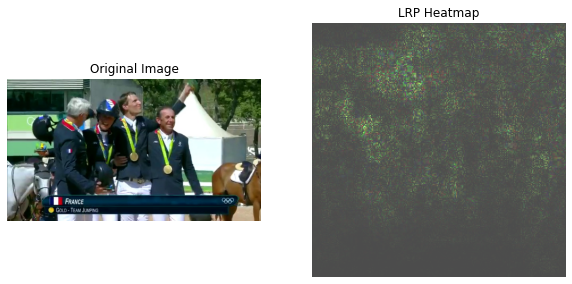

In [8]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Load trained model
model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Extract TimeDistributed MobileNetV2 from model
time_dist_layer = model.layers[0]  # TimeDistributed layer
time_dist_mobilenet = time_dist_layer.layer  # Extract MobileNetV2

# Define a function to compute LRP manually
def compute_lrp(image, model, target_class):
    """
    Compute LRP manually by propagating relevance from output layer to input.

    Args:
        image (numpy array): Preprocessed input image (224x224x3).
        model (tf.keras.Model): Pretrained MobileNetV2 model.
        target_class (int): Class index to explain.

    Returns:
        numpy array: LRP heatmap (same size as input image).
    """

    # Convert image into a tensor and expand batch dimension
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)

    # Forward pass to get predictions
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        preds = model(image_tensor)
        target_output = preds[0, target_class]  # Get output for target class

    # Compute gradient of target class w.r.t. input image
    grads = tape.gradient(target_output, image_tensor)
    grads = tf.abs(grads)  # Use absolute value to get positive relevance scores

    # Normalize relevance scores to [0,1]
    grads = grads.numpy().squeeze()
    heatmap = (grads - grads.min()) / (grads.max() - grads.min())

    return heatmap

# Function to apply LRP on an extracted frame
def apply_lrp_on_frame(frame_path, model, target_class=1):
    """
    Load a video frame, compute LRP, and visualize heatmap.

    Args:
        frame_path (str): Path to frame image.
        model (tf.keras.Model): Pretrained model.
        target_class (int): Index of class for LRP.

    Returns:
        None (displays heatmap).
    """

    # Load and preprocess frame
    image = cv2.imread(frame_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype("float32") / 255.0  # Normalize

    # Compute LRP heatmap
    lrp_heatmap = compute_lrp(image, time_dist_mobilenet, target_class)

    # Display original image and LRP heatmap
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(frame_path)[..., ::-1])  # Convert BGR to RGB
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(lrp_heatmap, cmap="jet", alpha=0.7)
    plt.axis("off")
    plt.title("LRP Heatmap")

    plt.show()

# Example usage (replace with your actual frame path)
apply_lrp_on_frame("/kaggle/input/extracted-video-frames-dataset/video_frames/frame_102.jpg", model, target_class=1)


In [4]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

# Load trained model
model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Extract TimeDistributed MobileNetV2 from model
time_dist_layer = model.layers[0]  # TimeDistributed layer
time_dist_mobilenet = time_dist_layer.layer  # Extract MobileNetV2

# Function to compute LRP heatmap
def compute_lrp(image, model, target_class):
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        preds = model(image_tensor)
        target_output = preds[0, target_class]  # Get output for target class

    grads = tape.gradient(target_output, image_tensor)
    grads = tf.abs(grads)  # Use absolute value for positive relevance

    grads = grads.numpy().squeeze()
    heatmap = (grads - grads.min()) / (grads.max() - grads.min())  # Normalize

    return heatmap

# Process all frames in the folder
def process_all_frames(frames_folder, output_folder, model, target_class=1):
    os.makedirs(output_folder, exist_ok=True)

    frame_files = sorted(os.listdir(frames_folder))  # Sort to maintain order

    for frame_file in frame_files:
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            continue  # Skip invalid frames

        frame = cv2.resize(frame, (224, 224))
        frame = frame.astype("float32") / 255.0  # Normalize

        lrp_heatmap = compute_lrp(frame, time_dist_mobilenet, target_class)

        # Save LRP heatmap as an image
        heatmap_path = os.path.join(output_folder, frame_file)
        plt.imsave(heatmap_path, lrp_heatmap, cmap="jet")

    print(f"LRP heatmaps saved in {output_folder}")

# Convert LRP heatmaps to a video
def create_lrp_video(heatmap_folder, output_video_path, fps=15):
    frame_files = sorted(os.listdir(heatmap_folder))  # Ensure correct order
    first_frame = cv2.imread(os.path.join(heatmap_folder, frame_files[0]))

    h, w, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    for frame_file in frame_files:
        frame_path = os.path.join(heatmap_folder, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            continue  # Skip invalid frames

        video_writer.write(frame)

    video_writer.release()
    print(f"LRP video saved as {output_video_path}")

# Define input and output paths
frames_folder = "/kaggle/input/extracted-video-frames-dataset/video_frames"  # Folder with video frames
heatmap_folder = "/kaggle/working/"  # Folder to save heatmaps
output_video = "lrp_output.mp4"  # Output video file

# Apply LRP to all frames
process_all_frames(frames_folder, heatmap_folder, model, target_class=1)



LRP heatmaps saved in /kaggle/working/


AttributeError: 'NoneType' object has no attribute 'shape'

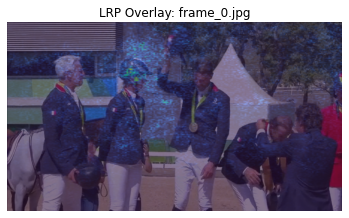

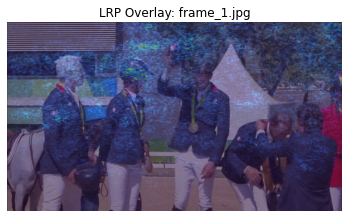

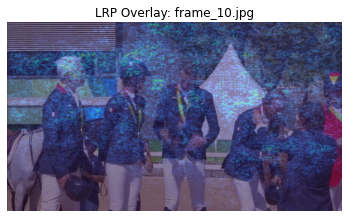

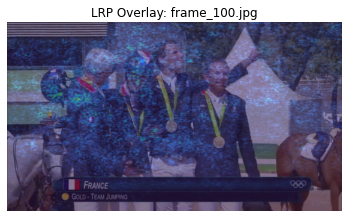

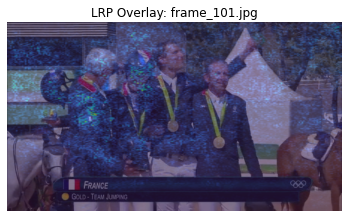

LRP heatmaps saved in lrp_overlay
LRP video saved as lrp_output.mp4


In [19]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

# Load trained model
model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Extract MobileNetV2 from TimeDistributed
time_dist_layer = model.layers[0]  # TimeDistributed layer
time_dist_mobilenet = time_dist_layer.layer  # Extract MobileNetV2

# Function to compute LRP heatmap
def compute_lrp(image, model, target_class):
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        preds = model(image_tensor)
        target_output = preds[0, target_class]  # Get output for target class

    grads = tape.gradient(target_output, image_tensor)
    grads = tf.abs(grads)  # Use absolute value for positive relevance

    grads = grads.numpy().squeeze()
    heatmap = (grads - grads.min()) / (grads.max() - grads.min())  # Normalize

    return heatmap

# Function to overlay heatmap on original image
def overlay_heatmap(frame, heatmap, alpha=0.6):
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit format
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Convert to BGR
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO)  # Change color map

    # Ensure heatmap has the same size as frame
    heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))

    # Ensure both images have 3 channels
    if len(frame.shape) == 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    overlay = cv2.addWeighted(frame, 1 - alpha, heatmap, alpha, 0)
    return overlay


# Process all frames in folder
def process_all_frames(frames_folder, output_folder, model, target_class=1):
    os.makedirs(output_folder, exist_ok=True)

    frame_files = sorted(os.listdir(frames_folder))  # Maintain order

    for frame_file in frame_files:
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            continue  # Skip invalid frames

        frame = cv2.resize(frame, (224, 224))
        frame = frame.astype("float32") / 255.0  # Normalize

        lrp_heatmap = compute_lrp(frame, time_dist_mobilenet, target_class)
        overlayed_frame = overlay_heatmap(cv2.imread(frame_path), lrp_heatmap)

        # Save LRP overlay image
        heatmap_path = os.path.join(output_folder, frame_file)
        cv2.imwrite(heatmap_path, overlayed_frame)

        # Display first 5 images for verification
        if frame_files.index(frame_file) < 5:
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(overlayed_frame, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title(f"LRP Overlay: {frame_file}")
            plt.show()

    print(f"LRP heatmaps saved in {output_folder}")

# Convert LRP heatmaps to a video
def create_lrp_video(heatmap_folder, output_video_path, fps=15):
    frame_files = sorted(os.listdir(heatmap_folder))
    first_frame = cv2.imread(os.path.join(heatmap_folder, frame_files[0]))

    h, w, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    for frame_file in frame_files:
        frame_path = os.path.join(heatmap_folder, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            continue

        video_writer.write(frame)

    video_writer.release()
    print(f"LRP video saved as {output_video_path}")

# Define paths
frames_folder = "/kaggle/input/extracted-video-frames-dataset/video_frames"
heatmap_folder = "lrp_overlay"
output_video = "lrp_output.mp4"

# Apply LRP to all frames and display first 5
process_all_frames(frames_folder, heatmap_folder, model, target_class=1)

# Convert heatmaps to video
create_lrp_video(heatmap_folder, output_video, fps=15)


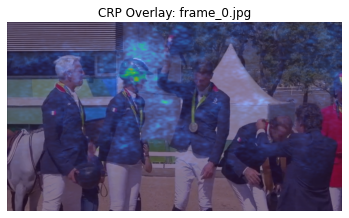

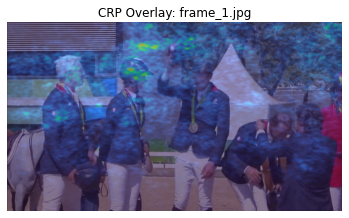

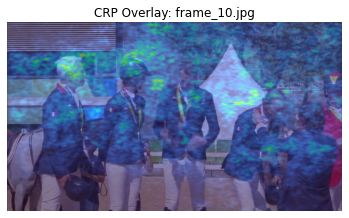

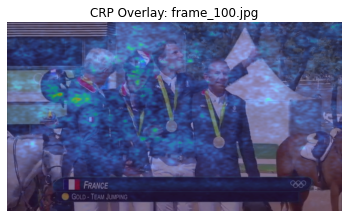

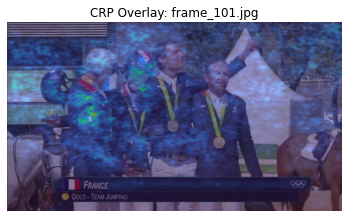

CRP heatmaps saved in crp_overlay
CRP video saved as crp_output.mp4


In [15]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

# Load trained model
model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Extract MobileNetV2 from TimeDistributed
time_dist_layer = model.layers[0]  # TimeDistributed layer
time_dist_mobilenet = time_dist_layer.layer  # Extract MobileNetV2

# Function to compute CRP heatmap
def compute_crp(image, model, target_class):
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        preds = model(image_tensor)
        target_output = preds[0, target_class]  # Get output for target class

    grads = tape.gradient(target_output, image_tensor)
    grads = tf.abs(grads)  # Use absolute value for positive relevance

    # Contextual normalization: Smooth out variations
    contextual_grads = cv2.GaussianBlur(grads.numpy().squeeze(), (3, 3), 0)


    heatmap = (contextual_grads - contextual_grads.min()) / (contextual_grads.max() - contextual_grads.min())  # Normalize

    return heatmap

# Function to overlay heatmap on original image
def overlay_heatmap(frame, heatmap, alpha=0.6):
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit format
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) 
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO)  # Change color map
# Convert to BGR
    
    # Ensure heatmap has the same size as frame
    heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))

    # Ensure both images have 3 channels
    if len(frame.shape) == 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    overlay = cv2.addWeighted(frame, 1 - alpha, heatmap, alpha, 0)
    return overlay


# Process all frames in folder
def process_all_frames(frames_folder, output_folder, model, target_class=1):
    os.makedirs(output_folder, exist_ok=True)

    frame_files = sorted(os.listdir(frames_folder))  # Maintain order

    for frame_file in frame_files:
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            continue  # Skip invalid frames

        frame = cv2.resize(frame, (224, 224))
        frame = frame.astype("float32") / 255.0  # Normalize

        crp_heatmap = compute_crp(frame, time_dist_mobilenet, target_class)
        overlayed_frame = overlay_heatmap(cv2.imread(frame_path), crp_heatmap)

        # Save CRP overlay image
        heatmap_path = os.path.join(output_folder, frame_file)
        cv2.imwrite(heatmap_path, overlayed_frame)

        # Display first 5 images for verification
        if frame_files.index(frame_file) < 5:
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(overlayed_frame, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title(f"CRP Overlay: {frame_file}")
            plt.show()

    print(f"CRP heatmaps saved in {output_folder}")

# Convert CRP heatmaps to a video
def create_crp_video(heatmap_folder, output_video_path, fps=15):
    frame_files = sorted(os.listdir(heatmap_folder))
    first_frame = cv2.imread(os.path.join(heatmap_folder, frame_files[0]))

    h, w, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    for frame_file in frame_files:
        frame_path = os.path.join(heatmap_folder, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            continue

        video_writer.write(frame)

    video_writer.release()
    print(f"CRP video saved as {output_video_path}")

# Define paths
frames_folder = "/kaggle/input/extracted-video-frames-dataset/video_frames"
heatmap_folder = "crp_overlay"
output_video = "crp_output.mp4"

# Apply CRP to all frames and display first 5
process_all_frames(frames_folder, heatmap_folder, model, target_class=1)

# Convert heatmaps to video
create_crp_video(heatmap_folder, output_video, fps=15)


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

# Load trained model
model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Extract MobileNetV2 from TimeDistributed
time_dist_layer = model.layers[0]  # TimeDistributed layer
time_dist_mobilenet = time_dist_layer.layer  # Extract MobileNetV2

# LIME Explainer
explainer = LimeImageExplainer()

# Function to apply LIME on a frame
def apply_lime(image, model, top_labels=1, num_features=5):
    def predict_fn(images):
        images = np.array([img for img in images])
        return model.predict(images)
    
    explanation = explainer.explain_instance(
        image, 
        predict_fn, 
        top_labels=top_labels, 
        hide_color=0, 
        num_samples=1000
    )
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=True, 
        num_features=num_features, 
        hide_rest=True
    )
    
    return mark_boundaries(temp, mask)

# Process all frames in folder
def process_all_frames_lime(frames_folder, output_folder, model):
    os.makedirs(output_folder, exist_ok=True)

    frame_files = sorted(os.listdir(frames_folder))
    for frame_file in frame_files:
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)
        
        if frame is None:
            continue

        frame = cv2.resize(frame, (224, 224))
        frame = frame.astype("float32") / 255.0  # Normalize
        
        lime_overlay = apply_lime(frame, time_dist_mobilenet)
        
        # Save LIME overlay image
        lime_path = os.path.join(output_folder, frame_file)
        plt.imsave(lime_path, lime_overlay)
        
        # Display first 5 images for verification
        if frame_files.index(frame_file) < 5:
            plt.figure(figsize=(6, 6))
            plt.imshow(lime_overlay)
            plt.axis("off")
            plt.title(f"LIME Overlay: {frame_file}")
            plt.show()

    print(f"LIME heatmaps saved in {output_folder}")

# Convert LIME heatmaps to a video
def create_lime_video(heatmap_folder, output_video_path, fps=15):
    frame_files = sorted(os.listdir(heatmap_folder))
    first_frame = cv2.imread(os.path.join(heatmap_folder, frame_files[0]))
    
    h, w, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    for frame_file in frame_files:
        frame_path = os.path.join(heatmap_folder, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            continue

        video_writer.write(frame)

    video_writer.release()
    print(f"LIME video saved as {output_video_path}")

# Define paths
frames_folder = "/kaggle/input/extracted-video-frames-dataset/video_frames"
lime_folder = "lime_overlay"
output_video = "lime_output.mp4"

# Apply LIME to all frames and display first 5
process_all_frames_lime(frames_folder, lime_folder, model)

# Convert LIME heatmaps to video
create_lime_video(lime_folder, output_video, fps=15)


In [20]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

# Load trained model
model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Extract MobileNetV2 from TimeDistributed
time_dist_layer = model.layers[0]  # TimeDistributed layer
time_dist_mobilenet = time_dist_layer.layer  # Extract MobileNetV2

# LIME Explainer
explainer = LimeImageExplainer()

# Function to apply LIME on a frame
def apply_lime(image, model, top_labels=1, num_features=5):
    def predict_fn(images):
        images = np.array([img for img in images])
        return model.predict(images)
    
    explanation = explainer.explain_instance(
        image, 
        predict_fn, 
        top_labels=top_labels, 
        hide_color=0, 
        num_samples=1000
    )
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=True, 
        num_features=num_features, 
        hide_rest=True
    )
    
    return mark_boundaries(temp, mask)

# Process all frames in folder
def process_all_frames_lime(frames_folder, output_folder, model):
    os.makedirs(output_folder, exist_ok=True)

    frame_files = sorted(os.listdir(frames_folder))
    for frame_file in frame_files:
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)
        
        if frame is None:
            continue

        frame = cv2.resize(frame, (224, 224))
        frame = frame.astype("float32") / 255.0  # Normalize
        
        lime_overlay = apply_lime(frame, time_dist_mobilenet)
        
        # Save LIME overlay image
        lime_path = os.path.join(output_folder, frame_file)
        plt.imsave(lime_path, lime_overlay)
        
        # Display first 5 images for verification
        if frame_files.index(frame_file) < 5:
            plt.figure(figsize=(6, 6))
            plt.imshow(lime_overlay)
            plt.axis("off")
            plt.title(f"LIME Overlay: {frame_file}")
            plt.show()

    print(f"LIME heatmaps saved in {output_folder}")

# Convert LIME heatmaps to a video
def create_lime_video(heatmap_folder, output_video_path, fps=15):
    frame_files = sorted(os.listdir(heatmap_folder))
    first_frame = cv2.imread(os.path.join(heatmap_folder, frame_files[0]))
    
    h, w, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    for frame_file in frame_files:
        frame_path = os.path.join(heatmap_folder, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            continue

        video_writer.write(frame)

    video_writer.release()
    print(f"LIME video saved as {output_video_path}")

# Define paths
frames_folder = "/kaggle/input/extracted-video-frames-dataset/video_frames"
lime_folder = "lime_overlay"
output_video = "lime_output.mp4"

# Apply LIME to all frames and display first 5
process_all_frames_lime(frames_folder, lime_folder, model)

# Convert LIME heatmaps to video
create_lime_video(lime_folder, output_video, fps=15)


  0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: index 839 is out of bounds for axis 1 with size 7

In [1]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs  # Modify based on your layer logic

    def get_config(self):
        config = super().get_config()
        return config  # Required to avoid the warning

# Load model with custom objects
model = tf.keras.models.load_model(
    "/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5",
    custom_objects={"CustomLayer": CustomLayer}  # Add any custom layers here
)

# Load your .h5 model
#model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Convert and save in TensorFlow SavedModel format
model.save("saved_model_dir")  # This creates a directory with the SavedModel format


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [11]:
import tensorflow as tf

# Load the trained .h5 model
model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Convert and save as .keras format
model.save("/kaggle/working/violence_detection_model.keras", save_format="keras")

print("✅ Model converted to .keras format!")


✅ Model converted to .keras format!


In [12]:
import tensorflow as tf

# Load the converted .keras model
model = tf.keras.models.load_model("/kaggle/working/violence_detection_model.keras")

# Check model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 2, 2, 1280)    2257984   
_________________________________________________________________
dropout (Dropout)            (None, 16, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 5120)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                1319168   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [16]:
import tensorflow as tf

# Load your existing H5 model
model = tf.keras.models.load_model("/kaggle/input/violence_detection_model/keras/default/1/violence_detection_model.h5")

# Save in the new `.keras` format
model.save("/kaggle/working/new_keras", save_format=".keras")

print("✅ Model successfully saved in .keras format!")


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


✅ Model successfully saved in .keras format!


In [17]:
!jupyter nbconvert --to html /kaggle/working/notebook.ipynb

[NbConvertApp] WARNING | pattern '/kaggle/working/notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]


In [21]:
!jupyter nbconvert --to html --template lab XAI-MobileNet,Bi-LSTM.ipynb

[NbConvertApp] WARNING | pattern 'XAI-MobileNet,Bi-LSTM.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--e

In [22]:
!jupyter nbconvert XAI-MobileNet,Bi-LSTM.ipynb --stdout

[NbConvertApp] WARNING | pattern 'XAI-MobileNet,Bi-LSTM.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--e